In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sed_scores_eval import intersection_based, package_dir, io
from time import time

import glob
import os
import pathlib

import datasets
import query_strategies as qs
import evaluate

In [3]:
# prepare the ground_truth.tsv and audio_durations.tsv files
emb_win_length = 1.0
emb_hop_length = emb_win_length / 4

emb_hop_length_str = '{:.2f}'.format(emb_hop_length)
emb_win_length_str = '{:.1f}'.format(emb_win_length)
class_name = 'me'

test_base_dir = '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/{}_{}_{}s/test_soundscapes_snr_0.0'.format(class_name, emb_win_length, emb_hop_length)
print(test_base_dir)
train_base_dir = test_base_dir.replace('test', 'train')
print(train_base_dir)

/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/me_1.0_0.25s/test_soundscapes_snr_0.0
/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/me_1.0_0.25s/train_soundscapes_snr_0.0


In [4]:
# Generate the ground_truth.tsv and audio_durations.tsv files for the training and test set
for base_dir in [train_base_dir, test_base_dir]:
    annotation_files = glob.glob(os.path.join(base_dir, '*.txt'))

    annotation_files = [f for f in annotation_files if 'embeddings' not in f]
    print(os.path.basename(base_dir))
    print("Number of soundscapes: ", len(annotation_files))

    with open(os.path.join(base_dir, 'ground_truth.tsv'), 'w') as gt_f:
        with open(os.path.join(base_dir, 'audio_durations.tsv'), 'w') as dur_f:
            gt_f.write('filename\tonset\toffset\tevent_label\n')
            dur_f.write('filename\tduration\n')
            for ann_file in annotation_files:
                with open(ann_file, 'r') as ann_f:
                    base_filename = os.path.basename(ann_file).replace('.txt', '.wav')
                    lines = ann_f.readlines()
                    for line in lines:
                        ls = line.split('\t')
                        row = '{}\t{}\t{}\t{}'.format(base_filename, ls[0], ls[1], ls[2])
                        gt_f.write(row)
                
                soundscape_basename = base_filename.replace('.wav', '')
                soundscape_length = qs.get_soundscape_length(base_dir, soundscape_basename)
                dur_f.write('{}\t{}\n'.format(soundscape_basename, soundscape_length))

train_soundscapes_snr_0.0
Number of soundscapes:  200
test_soundscapes_snr_0.0
Number of soundscapes:  200


# Derive the training scores for the training data

In [6]:
# test evaluation of the annotations to better understand the metric

# extract nonoverlapping timings with label and create train_scores.tsv
# 
# onset   offset   class1
# 1.0     2.0      0 
# 2.0     3.0      1
# (et cetera)
#
# save to train scores

# for OPT save to ground_truth.tsv
# filename	onset	offset	event_label
# test1.wav	3.98	4.86	class2
# test1.wav	9.05	10.0	class3
# test2.wav	0.0	    4.07	class1
# test2.wav	0.0	    8.54	class2
# test2.wav	5.43	7.21	class1

# load the annotations


# load timings and embeddings
result_dir  = '../results_test'
class_name  = 'me'
method_name = 'ADP'
idx_run     = '0'

sim_dir                     = os.path.join(result_dir, class_name)
run_dir                     = os.path.join(sim_dir, method_name, idx_run)
train_soundscape_file_paths = glob.glob(os.path.join(train_base_dir, '*.wav'))
train_annotation_file_paths = glob.glob(os.path.join(run_dir, 'train_annotations', '*.tsv'))
train_scores_dir            = os.path.join(run_dir, 'train_scores')

if not os.path.exists(train_scores_dir):
    os.makedirs(train_scores_dir)


def get_soundscape_basename(fp):
    return os.path.splitext(os.path.basename(fp))[0]

def get_soundscape_id(fp):
    return os.path.basename(fp).split('_')[-1].split('.')[0]

for train_soundscape_file_path in train_soundscape_file_paths:
    train_sounscape_basename = get_soundscape_basename(train_soundscape_file_path)

    train_annotation_file    = [fp for fp in train_annotation_file_paths if get_soundscape_id(fp) == get_soundscape_id(train_sounscape_basename)][0]

    timings, embeddings = datasets.load_timings_and_embeddings(train_base_dir, train_sounscape_basename)
    pos_ann = evaluate.get_positive_annotations(train_annotation_file)
    
    _, _, embs_label = evaluate.get_embeddings_3(pos_ann, train_base_dir, train_sounscape_basename, emb_win_length)

    taus = np.mean(timings, axis=1)
    window_timings = [(tau - emb_win_length / 2, tau + emb_win_length / 2) for tau in taus]

    idx_nonoverlapping = np.arange(len(window_timings)) % 4 == 0
    window_timings_nonoverlapping = np.array(window_timings)[idx_nonoverlapping]
    embs_label_nonoverlapping     = embs_label[idx_nonoverlapping]
    

    with open(os.path.join(train_scores_dir, train_sounscape_basename + '.tsv'), 'w') as f:
        f.write('onset\toffset\t{}\n'.format(class_name))
        for (s, e), l in zip(window_timings_nonoverlapping, embs_label_nonoverlapping):
            f.write('{}\t{}\t{}\n'.format(s, e, l))


# Evaluate label-quality on training data

In [11]:
# training data
gt_file             = os.path.join(train_base_dir, 'ground_truth.tsv')
audio_duration_file = os.path.join(train_base_dir, 'audio_durations.tsv')

# predictions
method_names = ['OPT', 'ADP', 'FIX', 'CPD']
plt.figure(figsize=(16,4))
for method_name in method_names:
    scores_dir = os.path.join(sim_dir, method_name, idx_run, 'train_scores')

    # TODO: read the paper and understand the parameters
    # PSDS parameters
    thr = 0.01
    dtc_threshold = thr
    gtc_threshold = thr
    cttc_threshold = None
    alpha_st = 1.0
    alpha_ct = 0.0
    max_efpr = 100.0

    psds, single_class_psds, psd_roc, single_class_psd_rocs = intersection_based.psds(
        scores          = scores_dir,
        ground_truth    = gt_file,
        audio_durations = audio_duration_file,
        dtc_threshold   = dtc_threshold, gtc_threshold=gtc_threshold,
        cttc_threshold  = cttc_threshold,
        alpha_ct        = alpha_ct,
        alpha_st        = alpha_st,
        unit_of_time    = 'hour',
        max_efpr        = max_efpr,
    )
    print('Method = {}, PSDS = {}'.format(method_name, psds))

    efpr, etpr = psd_roc

    plt.ylim(.0,.6)
    plt.xlim(0,100)
    plt.grid()
    plt.ylabel('eTPR')
    plt.xlabel('eFPR per hour')
    plt.step(efpr, etpr, lw=2, where='post')
plt.legend(method_names, loc='lower right')

Method = OPT, PSDS = 1.0
Method = ADP, PSDS = 1.0
Method = FIX, PSDS = 1.0
Method = CPD, PSDS = 1.0


# Evaluate the predictions on the test data

In [38]:
# Assumes that the evaluate_all.sh script has been run
# which produces the test_scores directory and the predictions
# for each method and soundscape

# test data
gt_file             = os.path.join(test_base_dir, 'ground_truth.tsv')
audio_duration_file = os.path.join(test_base_dir, 'audio_durations.tsv')

# predictions
method_names = ['OPT', 'ADP', 'FIX', 'CPD']
for method_name in method_names:
    scores_dir  = '../results_test/me/{}/0/scores/budget_1.0/'.format(method_name)

    # PSDS parameters
    thr = 0.2
    dtc_threshold = thr
    gtc_threshold = thr
    cttc_threshold = None
    alpha_st = 1.0
    alpha_ct = 0.0
    max_efpr = 100.0

    psds, single_class_psds, psd_roc, single_class_psd_rocs = intersection_based.psds(
        scores          = scores_dir,
        ground_truth    = gt_file,
        audio_durations = audio_duration_file,
        dtc_threshold   = dtc_threshold, gtc_threshold=gtc_threshold,
        cttc_threshold  = cttc_threshold,
        alpha_ct        = alpha_ct,
        alpha_st        = alpha_st,
        unit_of_time    = 'hour',
        max_efpr        = max_efpr,
    )
    print('Method = {}, PSDS = {}'.format(method_name, psds))

Method = OPT, PSDS = 0.54363
Method = ADP, PSDS = 0.52506
Method = FIX, PSDS = 0.49181666666666657
Method = CPD, PSDS = 0.4855600000000001


In [62]:
proba_files = glob.glob(os.path.join(test_base_dir, 'probas', '*.npy'))
print(proba_files)

header = 'onset\toffset\t{}'.format(class_name)
row = '{}\t{}\t{}'
for proba_file in proba_files:
    proba = np.load(proba_file)
    soundscape_basename = os.path.basename(proba_file).replace('.npy', '').replace('00000_', '')
    timings, embeddings = datasets.load_timings_and_embeddings(test_base_dir, soundscape_basename)
    taus = np.mean(timings, axis=1)

    scores_dir = os.path.join(test_base_dir, 'scores')
    if not os.path.exists(scores_dir):
        os.makedirs(scores_dir)

    with open(os.path.join(scores_dir, '{}.tsv'.format(soundscape_basename)), 'w') as proba_f:
        proba_f.write(header + '\n')
        for idx in range(len(taus)):
            if idx % 4 == 0:
                tau    = taus[idx]
                onset  = tau - emb_win_length / 2
                offset = tau + emb_win_length / 2
                p      = proba[idx]
                row_str = row.format(onset, offset, p)

                proba_f.write(row_str + '\n')

['/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0s_0.25s_rect_large_final/test_soundscapes_snr_0.0/probas/00000_soundscape_88.npy', '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0s_0.25s_rect_large_final/test_soundscapes_snr_0.0/probas/00000_soundscape_27.npy', '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0s_0.25s_rect_large_final/test_soundscapes_snr_0.0/probas/00000_soundscape_43.npy', '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0s_0.25s_rect_large_final/test_soundscapes_snr_0.0/probas/00000_soundscape_94.npy', '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0s_0.25s_rect_large_final/test_soundscapes_snr_0.0/probas/00000_soundscape_45.npy', '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0s_0.25s_rect_large_final/test_soundscapes_snr_0.0/probas/00000_soundscape_7.npy', '/mnt/storage_1/datasets/bioacoustic_sed/generated_datasets/baby_1.0s_0.25s_rect_large_final/t

In [77]:
# test data
test_base_dir       = pathlib.Path(test_base_dir)
gt_file             = test_base_dir / 'ground_truth.tsv'
audio_duration_file = test_base_dir / 'audio_durations.tsv'

# predictions
method_names = ['OPT', 'ADP', 'FIX', 'CPD']
for method_name in method_names:
    scores_dir  = '../results_test/baby/{}/0/scores/'.format(method_name)

    # PSDS scenario 1 settings (DCASE)
    dtc_threshold = 0.7
    gtc_threshold = 0.7
    cttc_threshold = None
    alpha_st = 1.0
    alpha_ct = 0.0
    max_efpr = 100.0

    psds, single_class_psds, psd_roc, single_class_psd_rocs = intersection_based.psds(
        scores          = scores_dir,
        ground_truth    = gt_file,
        audio_durations = audio_duration_file,
        dtc_threshold   = dtc_threshold, gtc_threshold=gtc_threshold,
        cttc_threshold  = cttc_threshold,
        alpha_ct        = alpha_ct,
        alpha_st        = alpha_st,
        unit_of_time    = 'hour',
        max_efpr        = max_efpr,
    )
    print('Method = {}, PSDS = {}'.format(method_name, psds))

Method = OPT, PSDS = 0.12447999999999998
Method = ADP, PSDS = 0.14229333333333333
Method = FIX, PSDS = 0.11508000000000002
Method = CPD, PSDS = 0.16257333333333335


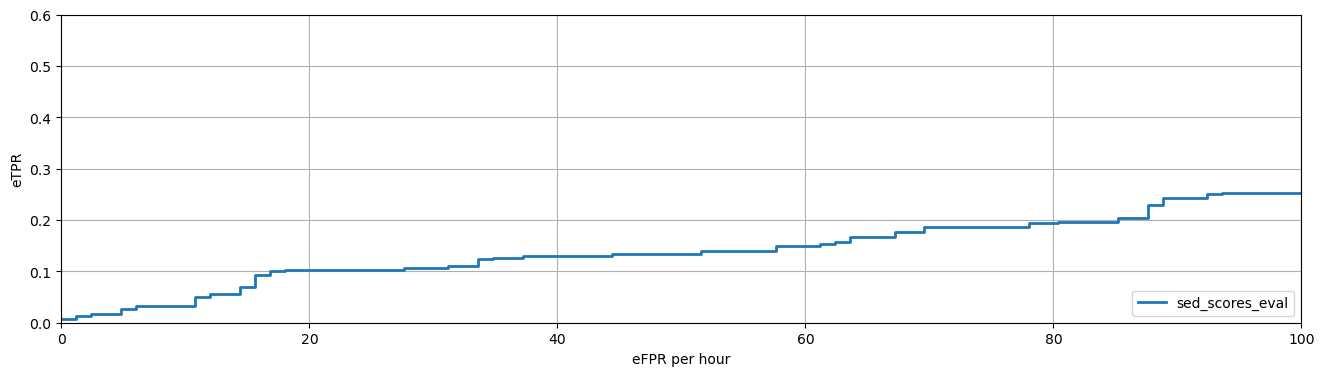

In [66]:
plt.figure(figsize=(16,4))
plt.ylim(.0,.6)
plt.xlim(0,100)
plt.grid()
plt.ylabel('eTPR')
plt.xlabel('eFPR per hour')
plt.step(efpr, etpr, lw=2, where='post')
plt.legend(['sed_scores_eval',], loc='lower right');

In [7]:

thresholds=np.linspace(0.01, 0.99, 50)
tic = time()
(
    psds_approx, single_class_psds_approx, psd_roc_approx, single_class_psd_rocs_approx
) = intersection_based.reference.approximate_psds(
    scores=test_data_dir / "eval" / "scores",
    ground_truth=test_data_dir / "eval" / "ground_truth.tsv",
    audio_durations=test_data_dir / "eval" / "audio_durations.tsv", 
    thresholds=thresholds,
    dtc_threshold=dtc_threshold, gtc_threshold=gtc_threshold,
    cttc_threshold=cttc_threshold if alpha_ct > 0. else None,
    alpha_ct=alpha_ct, alpha_st=alpha_st,
    unit_of_time='hour', max_efpr=100.,
)
print('PSDS:', psds_approx)
etpr_approx, efpr_approx = psd_roc_approx
time() - tic

/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/psds_eval/psds.py:631: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  on="x").fillna(method='ffill').fillna(value=0)
/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/psds_eval/psds.py:631: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  on="x").fillna(method='ffill').fillna(value=0)
/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/psds_eval/psds.py:631: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  on="x").fillna(method='ffill').fillna(value=0)
/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/psds_eval/psds.py:631: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future ve

PSDS: 0.3578927934100093


/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/psds_eval/psds.py:631: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  on="x").fillna(method='ffill').fillna(value=0)
/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/psds_eval/psds.py:631: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  on="x").fillna(method='ffill').fillna(value=0)
/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/psds_eval/psds.py:631: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  on="x").fillna(method='ffill').fillna(value=0)
/home/john/anaconda3/envs/torchaudio/lib/python3.11/site-packages/psds_eval/psds.py:631: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future ve

16.158051252365112

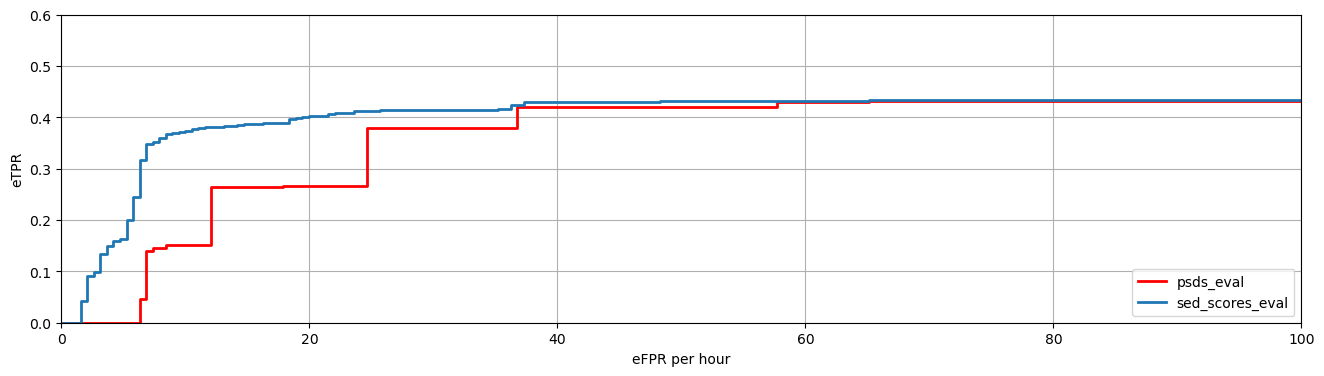

In [9]:
plt.figure(figsize=(16,4))
plt.ylim(.0,.6)
plt.xlim(0,100)
plt.grid()
plt.ylabel('eTPR')
plt.xlabel('eFPR per hour')
plt.step(efpr_approx, etpr_approx, 'r', lw=2, where='post')
plt.step(efpr, etpr, lw=2, where='post')
plt.legend([ 'psds_eval', 'sed_scores_eval',], loc='lower right')